# XGBoost Validation

In [ ]:
!python --version

Python 3.10.6


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys

Mounted at /content/gdrive


In [ ]:
!pip install xgboost

In [ ]:
#imports
print("Starting imports")
#basics
import time
print("Starting timer.")
startTime = time.time()

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns

#cleaning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler

#metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
# from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score


#XGBoost Specific
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import absolute

#hyperparams
from sklearn.model_selection import GridSearchCV

#h5 conversion
import h5py

#import validation tests
from scipy.spatial.distance import euclidean, cityblock
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from sklearn.model_selection import KFold

print("Imports Complete")

Starting imports
Starting timer.
Imports Complete


In [ ]:
datetimeCurr = datetime.datetime.now().strftime("%y%M%d_%H%M%S")
print(f"Current Datetime File Association: {datetimeCurr}")

Current Datetime File Association: 234624_184602


## Get Data

In [ ]:
#paths
mainPath = '/content/gdrive/MyDrive/REU 2023 Team 1: Ice Bed Topography Prediction/Research/Yi_Work/Final Process/'
data_full_ = mainPath + '0_Data/data_full_vMag.csv' #training and test combined
data_1201_ = mainPath + '0_Data/d1201_vMag.csv'
validation1201_ = mainPath + '0_Data/bed_BedMachine.h5' #solutions
saveMapTo_ = mainPath + "2_Results/"

In [ ]:
#read data in
# df_train = pd.read_csv(df_train_)
# df_test_x = pd.read_csv(df_test_)
# df_test_y = pd.read_csv(df_pred_)

print("Reading Data In_")
df_all = pd.read_csv(data_full_)

df1201 = pd.read_csv(data_1201_)

physSol = pd.DataFrame(np.array(h5py.File(validation1201_)['bed_BedMachine']))
print("Data read in completed.")

Reading Data In_
Data read in completed.


## RMSE Function

In [ ]:
print("Establishing RMSPE functions.")

Establishing RMSPE functions.


In [ ]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(((y_true - y_pred) / y_true))))*100

In [ ]:
def rmspe_1(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(y_true - y_pred) / y_true))*100

In [ ]:
print("Function established.")

Function established.


## Clean Data/Prepare Data

In [ ]:
print("Begin data cleaning.")

df1201 = df1201.drop(columns = ['Unnamed: 0.1'])
df_all = df_all.drop(columns = ['Unnamed: 0.1'])

#1201 drop location variables
df1201_feats = df1201.drop(columns = ['surf_x', 'surf_y'])

#df_all drop location variables
df_all_feats_target = df_all.drop(columns = ['surf_x', 'surf_y', 'track_bed_x', 'track_bed_y'])

#1201 order to align with df_all
df1201_feats_ordered = df1201_feats[['surf_vx', 'surf_vy', 'surf_elv', 'surf_dhdt', 'surf_SMB', 'v_mag']]

#set the feature variables to our independent characteristic variables
feature_cols = ['surf_vx', 'surf_vy', 'surf_elv', 'surf_dhdt', 'surf_SMB','v_mag']

#split into X and Y
X_given = df_all_feats_target[feature_cols]
Y_given = df_all_feats_target['track_bed_target']

#combine all known X and validation 1201 X for standardizing
X_all = np.concatenate((X_given, df1201_feats_ordered))
#make y into a dataframe to be standardized
Y_all = pd.DataFrame(Y_given)

print("Data cleaned.\nScaling beginning.")

#standardize
#Not setting feature range, let it be automatically determined
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_all_std = scaler_X.fit_transform(X_all)
Y_all_std = scaler_Y.fit_transform(Y_all)

#can alternatively use the MinMaxScaler
print("Scaling Complete.\nSplitting Data Beginning.")

#split of 1201 data from X_all_std
X_non1201 = X_all_std[0:632706,:]
X_1201_data = X_all_std[632706:, :]

# #generate a randomseed for training and testing split
# generated = np.random.randint(0,1000,1)[0]
# print(f"Generated random split for train-test: {generated}")
# # #generated = #
generated = 168

#set the train-test split
#60-40 showed the most promising from previous research and additional testing
train_size_ = .6
#split training and test from df_all
x_train, x_test, y_train, y_test = train_test_split(X_non1201, Y_all_std, train_size = train_size_, test_size = 1-train_size_, random_state = generated)

#get validation data
val_split = .2 #can change as needed
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 1-val_split, test_size = val_split, random_state = generated)

print(f"Data train-split complete with: {train_size_ * 100}% training, {(1- train_size_) * 100}% testing, {val_split*100}% validation")

Begin data cleaning.
Data cleaned.
Scaling beginning.
Scaling Complete.
Splitting Data Beginning.
Data train-split complete with: 60.0% training, 40.0% testing, 20.0% validation


## Modeling

In [ ]:
print("Building Model with Parameters")

Building Model with Parameters


In [ ]:
depth_ = 7 #higher --> Lower RMSE; lower --> more extreme highs and lows
iters_ = 350 #higher is higher R^2 and more reflection on the detail
eta_ = .25 #higher is more overfitting

In [ ]:
#define
model = XGBRegressor(
    max_depth=depth_,
    n_estimators=iters_,
    min_child_weight=0.25,
    subsample=0.8,
    eta=eta_,
    seed=generated)

In [ ]:
print("Training Model")

Training Model


In [ ]:
%%time
model.fit(
    x_train,
    y_train,
    eval_set=[(x_val, y_val)],
    verbose=False
    )

CPU times: user 4min 5s, sys: 458 ms, total: 4min 5s
Wall time: 3min 16s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.25, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=0.25, missing=nan,
             monotone_constraints=None, n_estimators=350, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [ ]:
%%time
print("Model Prediction Beginning")
y_pred_test = model.predict(x_test)

print("Model predicted.\nTransform data back to original scale.")

#get the original scale for the predicted Y
test_predict_full_scale = scaler_Y.inverse_transform(y_pred_test.reshape(-1,1))
y_test_given_full_range = scaler_Y.inverse_transform(y_test.reshape(-1,1))

Model Prediction Beginning
Model predicted.
Transform data back to original scale.
CPU times: user 3.79 s, sys: 7.77 ms, total: 3.8 s
Wall time: 2.54 s


In [ ]:
# Evaluate the model performance
print("Print testing stats statements.")

#LOSSES
print('RMSE:',np.sqrt(mean_squared_error(y_test_given_full_range, test_predict_full_scale)))
print('RMSE Percentage:',rmspe(y_test_given_full_range, test_predict_full_scale))
print('RMSE Percentage-1:',rmspe_1(y_test_given_full_range, test_predict_full_scale))
print('Mean Absolute Error:', mean_absolute_error(y_test_given_full_range, test_predict_full_scale))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test_given_full_range, test_predict_full_scale))
print('R^2 Score:', r2_score(y_test_given_full_range, test_predict_full_scale))

Print testing stats statements.
RMSE: 32.67978646085573
RMSE Percentage: 1453.64394168839
RMSE Percentage-1: 214.14640577887783
Mean Absolute Error: 22.2728335872512
Mean Absolute Percentage Error: 0.34093320863626686
R^2 Score: 0.9670683089432893


In [ ]:
%%time
# Evaluate the combined model on the non-bias training data

# Pass the latent samples through the decoder
y_pred_val = model.predict(x_val)

#rescale
val_predict_full_scale = scaler_Y.inverse_transform(y_pred_val.reshape(-1,1))
y_val_given_full_range = scaler_Y.inverse_transform(y_val.reshape(-1,1))

# Evaluate the model performance
print("Print validation stats statements.")

#LOSSES
print('RMSE:',np.sqrt(mean_squared_error(y_val_given_full_range, val_predict_full_scale)))
print('RMSE Percentage:',rmspe(y_val_given_full_range, val_predict_full_scale))
print('Mean Absolute Error:', mean_absolute_error(y_val_given_full_range, val_predict_full_scale))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_val_given_full_range, val_predict_full_scale))
print('R^2 Score:', r2_score(y_val_given_full_range, val_predict_full_scale))

Print validation stats statements.
RMSE: 32.284464365975296
RMSE Percentage: 12894.338512283366
Mean Absolute Error: 22.13960268173217
Mean Absolute Percentage Error: 1.0216433060319823
R^2 Score: 0.9673897122924211
CPU times: user 1.18 s, sys: 3.93 ms, total: 1.19 s
Wall time: 648 ms


In [ ]:
print("Graph density of validation predictions and known")

Graph density of validation predictions and known


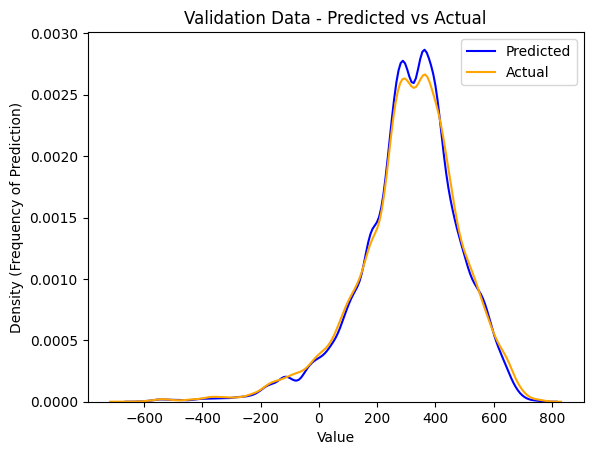

In [ ]:
sns.kdeplot(val_predict_full_scale.flatten(), label='Predicted', color = "blue")
sns.kdeplot(y_val_given_full_range.flatten(), label='Actual', color = "orange")
plt.xlabel('Value')
plt.ylabel('Density (Frequency of Prediction)')
plt.title('Validation Data - Predicted vs Actual')
plt.legend()

# 1201 Prediction

In [ ]:
print("Predicting 1201")
start1201Prediction = time.time()

y_pred_1201 = model.predict(X_1201_data)
pred1201_normScale = scaler_Y.inverse_transform(y_pred_1201.reshape(-1,1))

end1201Prediction = time.time()
print(f"Predicting 1201 Complete.\nTime taken: {end1201Prediction-start1201Prediction:.03f}ms")

Predicting 1201
Predicting 1201 Complete.
Time taken: 12.751ms


In [ ]:
print("Converting 1201 prediction 1201 shape.")

y_Predict_1201_full_flatten=pred1201_normScale.flatten()
prediction_on_1201_2D=y_Predict_1201_full_flatten.reshape(1201,1201)

print("1201 ready for validation checks.")

Converting 1201 prediction 1201 shape.
1201 ready for validation checks.


# Validation

In [ ]:
# #LOSSES 1201 Predicted vs. Physics Model
# print('RMSE:',np.sqrt(mean_squared_error(physSol, prediction_on_1201_2D)))
# # print('RMSE Percentage:',rmspe(physSol, prediction_on_1201_2D))
# print('Mean Absolute Error:', mean_absolute_error(physSol, prediction_on_1201_2D))
# # print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(physSol, prediction_on_1201_2D))
# print('R^2 Score:', r2_score(physSol, prediction_on_1201_2D))


In [ ]:
print("Running KFold Validation & Comparing Predicted 1201 Data Frame to Physics Model.")

Running KFold Validation & Comparing Predicted 1201 Data Frame to Physics Model.


In [ ]:
d1201Comparison = pd.DataFrame(prediction_on_1201_2D)

In [ ]:
def compare_dataframes(df1, df2):

    df1_values = df1.values.flatten()
    df1_index = df1.index
    df1_columns = df1.columns

    df2_values = df2.values.flatten()
    df2_index = df2.index
    df2_columns = df2.columns

    # Euclidean Distance
    euclidean_dist = euclidean(df1_values, df2_values)
    print(f"Euclidean Distance: {euclidean_dist}")

    # Cosine Similarity
    cosine_sim = cosine_similarity(df1_values.reshape(1, -1), df2_values.reshape(1, -1)).mean()
    print(f"Cosine Similarity: {round(cosine_sim * 100, 3)}%")

    # Pearson Correlation Coefficient
    pearson_corr, _ = pearsonr(df1_values, df2_values)
    print(f"Pearson Correlation Coefficient: {round(pearson_corr * 100, 3)}%")
    return



compare_dataframes(d1201Comparison, physSol)

Euclidean Distance: 96433.46875
Cosine Similarity: 97.688%
Pearson Correlation Coefficient: 80.611%


In [ ]:
# %%time
# # Set the number of folds for k-fold cross-validation
# k = 2 #change for the number of validation checks needed; min = 2.

# # Perform k-fold cross-validation
# kf = KFold(n_splits=k, shuffle=True, random_state=42) #leaving standard 42 seed for KFold.
# fold = 1 #initialize fold count for print statements

# # Lists to collect scores for plotting
# rmse_scores = []
# rmse_percentage_scores = []
# mae_scores = []
# mape_scores = []
# r2_scores = []

# for train_index, val_index in kf.split(X_non1201):
#     print(f"Fold {fold} Starting")

#     # Split the data into training and validation sets
#     x_train, x_val = X_non1201[train_index], X_non1201[val_index]
#     y_train, y_val = Y_all_std[train_index], Y_all_std[val_index]

#     # Fit the model on the training data
#     model.fit(x_train, y_train, eval_set=[(x_val, y_val)], verbose=False)

#     # Evaluate the model on the validation data
#     y_pred_val = model.predict(x_val)
#     val_predict_full_scale = scaler_Y.inverse_transform(y_pred_val.reshape(-1, 1))
#     y_val_given_full_range = scaler_Y.inverse_transform(y_val.reshape(-1, 1))

#     # Calculate the scores for this fold
#     rmse = np.sqrt(mean_squared_error(y_val_given_full_range, val_predict_full_scale))
#     rmse_percentage = rmspe(y_val_given_full_range, val_predict_full_scale)
#     mae = mean_absolute_error(y_val_given_full_range, val_predict_full_scale)
#     mape = mean_absolute_percentage_error(y_val_given_full_range, val_predict_full_scale)
#     r2 = r2_score(y_val_given_full_range, val_predict_full_scale)

#     # Append the scores to the respective lists
#     rmse_scores.append(rmse)
#     rmse_percentage_scores.append(rmse_percentage)
#     mae_scores.append(mae)
#     mape_scores.append(mape)
#     r2_scores.append(r2)

#     # Print validation stats for this fold
#     # print('RMSE:', rmse)
#     # print('RMSE Percentage:', rmse_percentage)
#     # print('Mean Absolute Error:', mae)
#     # print('Mean Absolute Percentage Error:', mape)
#     # print('R^2 Score:', r2)
#     # print()

#     # Update the fold number
#     print(f"Fold {fold} Complete")
#     fold += 1


In [ ]:
# # Plotting KFold validation metrics
# # Plotting subplots
# fig, axs = plt.subplots(2, 3, figsize=(12, 8))
# fig.suptitle('Cross-Validation Metrics')

# # Plot RMSE
# axs[0, 0].bar(range(1, k+1), rmse_scores)
# axs[0, 0].set_title('RMSE')
# axs[0, 0].set_xlabel('Fold')
# axs[0, 0].set_ylabel('RMSE')
# axs[0, 0].plot(range(1, k+1), rmse_scores, 'r--')

# # Label high and low points
# max_rmse_index = np.argmax(rmse_scores)
# min_rmse_index = np.argmin(rmse_scores)
# axs[0, 0].text(max_rmse_index+1, rmse_scores[max_rmse_index], f'Highest: {rmse_scores[max_rmse_index]:.2f}', ha='center', va='bottom')
# axs[0, 0].text(min_rmse_index+1, rmse_scores[min_rmse_index], f'Lowest: {rmse_scores[min_rmse_index]:.2f}', ha='center', va='top')

# # Plot RMSE Percentage
# axs[0, 1].bar(range(1, k+1), rmse_percentage_scores)
# axs[0, 1].set_title('RMSE Percentage')
# axs[0, 1].set_xlabel('Fold')
# axs[0, 1].set_ylabel('RMSE Percentage')
# axs[0, 1].plot(range(1, k+1), rmse_percentage_scores, 'r--')

# # Label high and low points
# max_rmse_percentage_index = np.argmax(rmse_percentage_scores)
# min_rmse_percentage_index = np.argmin(rmse_percentage_scores)
# axs[0, 1].text(max_rmse_percentage_index+1, rmse_percentage_scores[max_rmse_percentage_index], f'Highest: {rmse_percentage_scores[max_rmse_percentage_index]:.2f}', ha='center', va='bottom')
# axs[0, 1].text(min_rmse_percentage_index+1, rmse_percentage_scores[min_rmse_percentage_index], f'Lowest: {rmse_percentage_scores[min_rmse_percentage_index]:.2f}', ha='center', va='top')

# # Plot Mean Absolute Error
# axs[0, 2].bar(range(1, k+1), mae_scores)
# axs[0, 2].set_title('Mean Absolute Error')
# axs[0, 2].set_xlabel('Fold')
# axs[0, 2].set_ylabel('Mean Absolute Error')
# axs[0, 2].plot(range(1, k+1), mae_scores, 'r--')

# # Label high and low points
# max_mae_index = np.argmax(mae_scores)
# min_mae_index = np.argmin(mae_scores)
# axs[0, 2].text(max_mae_index+1, mae_scores[max_mae_index], f'Highest: {mae_scores[max_mae_index]:.2f}', ha='center', va='bottom')
# axs[0, 2].text(min_mae_index+1, mae_scores[min_mae_index], f'Lowest: {mae_scores[min_mae_index]:.2f}', ha='center', va='top')

# # Plot Mean Absolute Percentage Error
# axs[1, 0].bar(range(1, k+1), mape_scores)
# axs[1, 0].set_title('Mean Absolute Percentage Error')
# axs[1, 0].set_xlabel('Fold')
# axs[1, 0].set_ylabel('Mean Absolute Percentage Error')
# axs[1, 0].plot(range(1, k+1), mape_scores, 'r--')

# # Label high and low points
# max_mape_index = np.argmax(mape_scores)
# min_mape_index = np.argmin(mape_scores)
# axs[1, 0].text(max_mape_index+1, mape_scores[max_mape_index], f'Highest: {mape_scores[max_mape_index]:.2f}', ha='center', va='bottom')
# axs[1, 0].text(min_mape_index+1, mape_scores[min_mape_index], f'Lowest: {mape_scores[min_mape_index]:.2f}', ha='center', va='top')

# # Plot R^2 Score
# axs[1, 1].bar(range(1, k+1), r2_scores)
# axs[1, 1].set_title('R^2 Score')
# axs[1, 1].set_xlabel('Fold')
# axs[1, 1].set_ylabel('R^2 Score')
# axs[1, 1].plot(range(1, k+1), r2_scores, 'r--')

# # Label high and low points
# max_r2_index = np.argmax(r2_scores)
# min_r2_index = np.argmin(r2_scores)
# axs[1, 1].text(max_r2_index+1, r2_scores[max_r2_index], f'Highest: {r2_scores[max_r2_index]:.2f}', ha='center', va='bottom')
# axs[1, 1].text(min_r2_index+1, r2_scores[min_r2_index], f'Lowest: {r2_scores[min_r2_index]:.2f}', ha='center', va='top')

# # Hide the empty subplot
# axs[1, 2].axis('off')
# plt.tight_layout()
# plt.show()

d1 = my predictions  
d2 = physics model

In [ ]:
#transpose the datasets to face the correct NSEW directions.
data_set1 = np.transpose(d1201Comparison)
data_set1 = np.flipud(data_set1)
data_set2 = np.transpose(physSol) #solution
data_set2 = np.flipud(data_set2)

Current Datetime File Association: 230724_185000


<ipython-input-32-fded1e9b8fdf>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,0].set_yticklabels(reversed(axs[0,0].get_yticklabels()))  # Reverse the y-axis tick labels
<ipython-input-32-fded1e9b8fdf>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,1].set_yticklabels(reversed(axs[0,1].get_yticklabels()))  # Reverse the y-axis tick labels


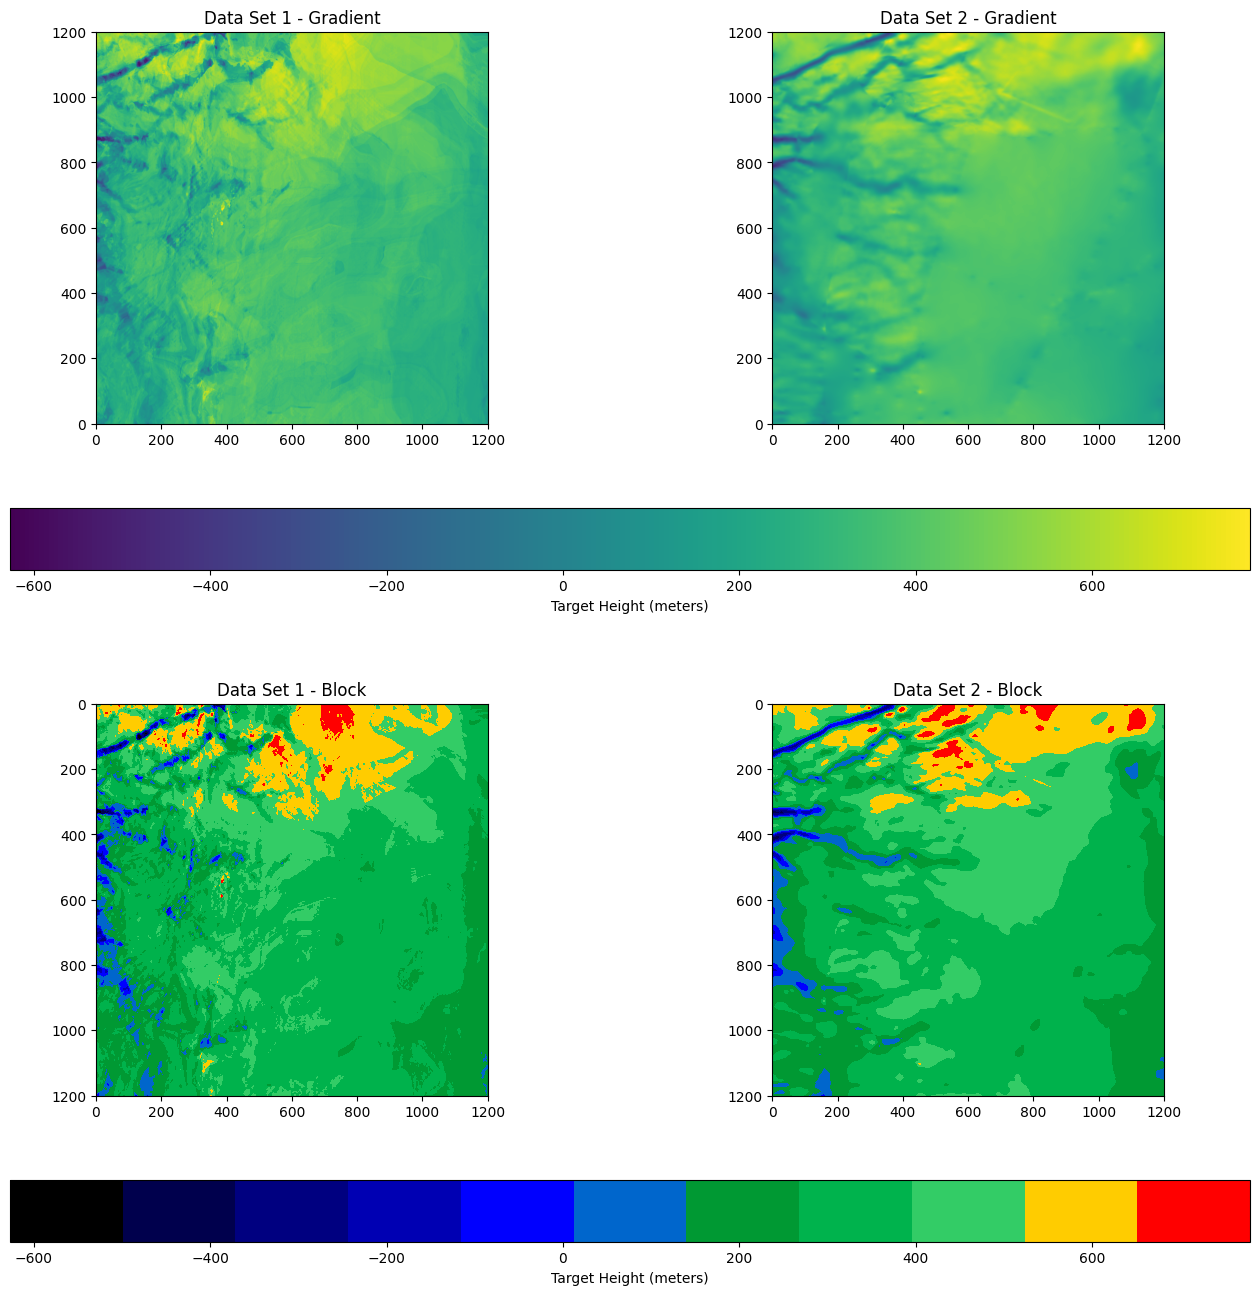

In [ ]:
datetimeCurr = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
print(f"Current Datetime File Association: {datetimeCurr}")

# Determine the minimum and maximum values for both data sets
min_value = min(data_set1.flatten().min(), data_set2.flatten().min())
max_value = data_set2.flatten().max()

# Create a figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 16))

# Plot the first data set with shared color scale
im1 = axs[0,0].imshow(data_set1, vmin=min_value, vmax=max_value)
axs[0,0].set_title('Data Set 1 - Gradient')
axs[0,0].set_yticklabels(reversed(axs[0,0].get_yticklabels()))  # Reverse the y-axis tick labels


# Plot the second data set with shared color scale
im2 = axs[0,1].imshow(data_set2, vmin=min_value, vmax=max_value)
axs[0,1].set_title('Data Set 2 - Gradient')
axs[0,1].set_yticklabels(reversed(axs[0,1].get_yticklabels()))  # Reverse the y-axis tick labels

# Define the colormap
colors = [
    (0.0, 0.0, 0.0),    # Black
    (0.0, 0.0, 0.3),    # Darker blue
    (0.0, 0.0, 0.5),    # Dark blue
    (0.0, 0.0, 0.7),    # blue
    (0.0, 0.0, 1.0),    # Blue
    (0.0, 0.4, 0.8),    # Lighter blue
    (0.0, 0.6, 0.2),    # Dark green
    (0.0, 0.7, 0.3),    # Green
    (0.2, 0.8, 0.4),    # Light green
    (1.0, 0.8, 0.0),    # Orange
    (1.0, 0.0, 0.0),    # Red
]
mapColor = LinearSegmentedColormap.from_list('WaterTreesMountains', colors)

#PLOT WITH BLOCK Color
cmap = ListedColormap(colors)

im3 = axs[1, 0].imshow(data_set1, vmin=min_value, vmax=max_value, cmap=cmap)
axs[1, 0].set_title('Data Set 1 - Block')

# Plot the second data set with block color scale
im4 = axs[1, 1].imshow(data_set2, vmin=min_value, vmax=max_value, cmap=cmap)
axs[1, 1].set_title('Data Set 2 - Block')

# Add colorbars to the plots
fig.colorbar(im2, label="Target Height (meters)", ax=axs[0, :], location='bottom')
fig.colorbar(im4, label="Target Height (meters)", ax=axs[1, :], location='bottom')

# Save & Display the plot
plt.savefig(saveMapTo_ + f"/XGBT4M_Results_{datetimeCurr}_D{depth_}I{iters_}E{eta_}.png")
plt.show()

In [ ]:
print("Plot density of 1201 vs physics model predictions")

Plot density of 1201 vs physics model predictions


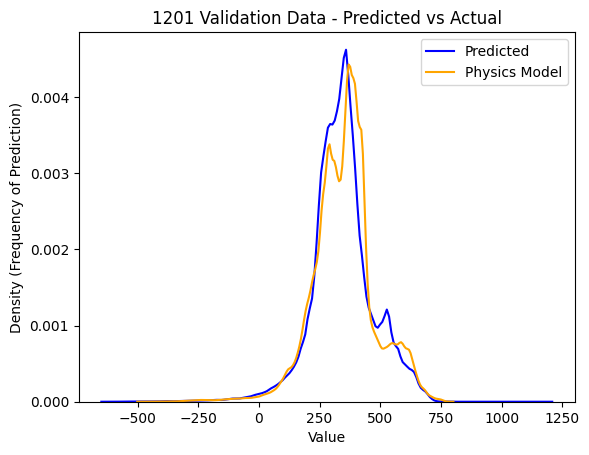

In [ ]:
sns.kdeplot(data_set1.flatten(), label='Predicted', color = "blue")
sns.kdeplot(data_set2.flatten(), label='Physics Model', color = "orange")
plt.xlabel('Value')
plt.ylabel('Density (Frequency of Prediction)')
plt.title('1201 Validation Data - Predicted vs Actual')
plt.legend()

In [ ]:
endTime = time.time()
print(f"Total Time Taken: {endTime - startTime:.03f}ms")
print("XGBT4M COMPLETE")

Total Time Taken: 263.911ms
XGBT4M COMPLETE
